# Pre-Notebook Setup (automated)

This cell guides setup and runs automated checks for reproducibility. You can run the helper scripts from a PowerShell environment (recommended):

- To create / update a Conda environment using `environment.yml`:
  ```powershell
  ./setup_and_run.ps1 -CreateCondaEnv -EnvName bigdata
  ```

- To install pip requirements into the currently active Python:
  ```powershell
  ./setup_and_run.ps1 -InstallPipRequirements
  ```

- To run quick environment checks (dependency pins, pyspark smoke test) and the PySpark preprocessing step:
  ```powershell
  ./setup_and_run.ps1 -RunPySparkPreprocess
  ```

Note: When running the notebook from the Jupyter UI with a kernel that matches the environment created above, you may also execute the notebook using `papermill` with `-RunNotebook` to produce a reproducible executed notebook copy.  

# 00 - Data Preprocessing & EDA

This notebook performs exploratory data analysis (EDA), creates reproducible preprocessing pipelines, precomputes embeddings (optional), engineers features, and saves processed artifacts for downstream modeling. It follows the agreed PRD data cleaning strategy and persists artifacts to `data/processed/v1/`, `models/pipelines/`, and `results/` for reproducibility.

In [17]:
# Cell: Import libraries & setup
import os, sys, json, logging, importlib, re, subprocess
from pathlib import Path
from datetime import datetime
import numpy as np
import pandas as pd
from IPython.display import display, clear_output

# --- Environment Fixes (Java & Spark) ---
def fix_environment():
    # 0. Clear potentially harmful global options that break Java 8 checks
    if 'JAVA_TOOL_OPTIONS' in os.environ:
        print(f"Unsetting JAVA_TOOL_OPTIONS ({os.environ['JAVA_TOOL_OPTIONS']}) to avoid conflicts.")
        del os.environ['JAVA_TOOL_OPTIONS']

    # 1. Unset SPARK_HOME to avoid conflicts with pip-installed pyspark.
    #    However, we MUST set HADOOP_HOME on Windows for winutils.exe.
    #    We also clear CLASSPATH to avoid loading conflicting JARs from other installations.
    for env_var in ['SPARK_HOME', 'CLASSPATH', 'HADOOP_CLASSPATH', 'SPARK_DIST_CLASSPATH']:
        if env_var in os.environ:
            print(f"Unsetting {env_var} ({os.environ[env_var]}) to avoid conflicts.")
            del os.environ[env_var]

    # 1.1 Ensure HADOOP_HOME is set correctly for Windows (requires winutils.exe)
    if 'HADOOP_HOME' not in os.environ:
        # Try standard location
        if os.path.exists(r'C:\hadoop\bin\winutils.exe'):
            os.environ['HADOOP_HOME'] = r'C:\hadoop'
            print(f"Setting HADOOP_HOME to {os.environ['HADOOP_HOME']}")
        else:
            print("Warning: HADOOP_HOME not set and C:\\hadoop\\bin\\winutils.exe not found. Spark file operations may fail on Windows.")
    else:
        print(f"HADOOP_HOME is set to: {os.environ['HADOOP_HOME']}")
    
    # Add HADOOP_HOME/bin to PATH if not present
    if 'HADOOP_HOME' in os.environ:
        hadoop_bin = os.path.join(os.environ['HADOOP_HOME'], 'bin')
        if hadoop_bin not in os.environ['PATH']:
             os.environ['PATH'] = hadoop_bin + os.pathsep + os.environ['PATH']

    # 1.5 Set PYSPARK_PYTHON to the current python executable to avoid "python3" not found errors on Windows
    print(f"Setting PYSPARK_PYTHON to {sys.executable}")
    os.environ['PYSPARK_PYTHON'] = sys.executable
    os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

    # 2. Check Java Version and attempt to fix if Java 8 is detected
    needs_fix = False
    try:
        # Check java on PATH
        java_cmd = "java"
        if "JAVA_HOME" in os.environ:
            java_cmd = str(Path(os.environ["JAVA_HOME"]) / "bin" / "java")

        output = subprocess.check_output([java_cmd, "-version"], stderr=subprocess.STDOUT).decode()
        if 'version "1.8' in output or 'version "8"' in output:
            print("Warning: Java 8 detected. Spark 3.5.x requires Java 17.")
            needs_fix = True
        else:
            print("Java version check passed.")
    except Exception as e:
        print("Java check failed (likely due to env mismatch). Attempting to find Java 17...", e)
        needs_fix = True

    if needs_fix:
        # Attempt to find Java 17 in common Windows locations
        candidates = []
        for prog_files in [r"C:\Program Files", r"C:\Program Files (x86)"]:
            p = Path(prog_files)
            candidates.extend(p.glob("Eclipse Adoptium/jdk-17*"))
            candidates.extend(p.glob("Java/jdk-17*"))
            candidates.extend(p.glob("Zulu/zulu-17*"))
            candidates.extend(p.glob("Microsoft/jdk-17*"))

        if candidates:
            best_java = candidates[0]
            print(f"Found Java 17 at: {best_java}")
            print("Setting JAVA_HOME and PATH for this session.")
            os.environ["JAVA_HOME"] = str(best_java)
            os.environ["PATH"] = str(best_java / "bin") + os.pathsep + os.environ["PATH"]
        else:
            print("CRITICAL: Java 17 not found. Please run `scripts/check_java_and_install_jdk.ps1` to install it.")

fix_environment()
# ----------------------------------------

# Spark imports (safe)
try:
    import pyspark
    from pyspark.sql import SparkSession
    from pyspark.sql.functions import col, monotonically_increasing_id
    from pyspark.sql import functions as F
    from pyspark.sql import types as T
    print('pyspark package version:', pyspark.__version__)
except Exception as e:
    print('PySpark import warning:', e)

# Setup logging for notebook
LOG = logging.getLogger('notebook')
if not LOG.handlers:
    logging.basicConfig(format='%(asctime)s %(levelname)s: %(message)s', level=logging.INFO)

# Ensure SparkSession exists (create a local one if needed) with robust fallbacks
if 'spark' not in globals() or spark is None:
    spark = None

# 1. Try to get active session
try:
    spark = SparkSession.getActiveSession()
    if spark:
        print("Using existing active SparkSession:", spark.version)
except Exception:
    spark = None

# 2. Try builder.getOrCreate()
if spark is None:
    try:
        # Add extra java options for Java 17+ module access if needed
        spark = SparkSession.builder \
            .master('local[2]') \
            .appName('notebook-local') \
            .config("spark.driver.extraJavaOptions", "--add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED") \
            .config("spark.executor.extraJavaOptions", "--add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED") \
            .config("spark.pyspark.python", sys.executable) \
            .config("spark.pyspark.driver.python", sys.executable) \
            .getOrCreate()
        print('Spark session started (local[2]):', spark.version)
    except Exception as e:
        print('Warning: Could not create SparkSession via builder:', e)
        spark = None

# 3. Fallback to existing SparkContext if present
if spark is None:
    try:
        from pyspark import SparkContext
        sc = SparkContext.getOrCreate()
        # If there's an existing SparkContext, create SparkSession from it
        try:
            spark = SparkSession(sc)
            print('Recovered existing SparkSession from SparkContext:', spark.version)
        except Exception as e:
            # In rare cases constructing SparkSession with the existing SC fails; still keep sc
            print('Recovered SparkContext, but could not create SparkSession object; sc exists, version info might be in log:', e)
            spark = None
    except Exception as e:
        print('No SparkContext found or could not recover:', e)
        spark = None

# 4. Final assertion and diagnostics
if spark is None:
    # Helpful diagnostics to guide the user
    print('\nFATAL: SparkSession could not be created or recovered in this notebook session.')
    print('Suggestions:')
    print(' - Restart the kernel and re-run the setup cell to ensure no stale contexts are present.')
    print(' - Ensure you are not running another Spark process that holds a JVM context.')
    print(' - Try running the helper scripts from a fresh shell with Java 17 and the same Python kernel activated:')
    print('     Remove-Item Env:\JAVA_TOOL_OPTIONS -ErrorAction SilentlyContinue; Remove-Item Env:\SPARK_HOME -ErrorAction SilentlyContinue; $env:JAVA_HOME="C:\\Program Files\\Eclipse Adoptium\\jdk-17.0.16.8-hotspot"; $env:PATH = $env:JAVA_HOME + "\\bin;" + $env:PATH; .\\.venv310\\Scripts\\Activate.ps1; python -c "import pyspark; print(pyspark.__version__)"')
    raise RuntimeError('SparkSession creation failed; see diagnostics above.')

# Basic environment diagnostic
print('Spark is available; version:', spark.version)
print('Current working directory:', Path.cwd())
# Fix path check to look up one level if in notebooks dir
data_path = Path('data/stock_market_crash_2022.csv')
if not data_path.exists() and Path('../data/stock_market_crash_2022.csv').exists():
    print('Found dataset in ../data/ (adjusting expectations)')
else:
    print('Found dataset in data dir:', data_path.exists())
print('Results dir exists:', Path('results').exists())

HADOOP_HOME is set to: C:\hadoop
Setting PYSPARK_PYTHON to c:\Users\swkan\Downloads\VSCode\Big Data Group Project\.venv310\Scripts\python.exe
Java version check passed.
pyspark package version: 3.5.7
Using existing active SparkSession: 3.5.7
Spark is available; version: 3.5.7
Current working directory: c:\Users\swkan\Downloads\VSCode\Big Data Group Project\notebooks
Found dataset in ../data/ (adjusting expectations)
Results dir exists: True


In [18]:
# Cell: Define UDFs and Helper Functions
# These functions are adapted from scripts/preprocess_pyspark.py to run interactively in the notebook.

from pyspark.sql.functions import pandas_udf
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType, BooleanType
import pandas as pd
import re
import unicodedata
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

def clean_text_py(s: pd.Series) -> pd.Series:
    URL_RE = re.compile(r"https?://\S+|www\.\S+")
    MENTION_RE = re.compile(r"@\w+")
    TICKER_RE = re.compile(r"\$[A-Za-z]+")

    def norm(x: str) -> str:
        if pd.isna(x):
            return ""
        x = str(x)
        try:
            x = unicodedata.normalize("NFKC", x)
        except Exception:
            pass
        x = URL_RE.sub(" <URL> ", x)
        x = MENTION_RE.sub(" <USER> ", x)
        x = TICKER_RE.sub(" <TICKER> ", x)
        x = re.sub(r"\s+", " ", x)
        return x.strip()

    return s.apply(norm)

def features_py(s: pd.Series) -> pd.DataFrame:
    vader = SentimentIntensityAnalyzer()

    def compute(row: str):
        if pd.isna(row):
            row = ""
        # Use a safe length for caps ratio
        chars = len(row)
        char_count = chars
        word_count = len(row.split())
        hashtag_count = row.count('#')
        mention_count = len(re.findall(r"@\w+", row))
        ticker_count = len(re.findall(r"\$[A-Za-z]+", row))
        caps_ratio = sum(1 for c in row if c.isupper()) / (chars + 1e-9)
        emoji_count = sum(1 for c in row if ord(c) > 10000)
        has_nonascii = any(ord(c) > 127 for c in row)
        vader_scores = vader.polarity_scores(row)
        return (
            char_count,
            word_count,
            hashtag_count,
            mention_count,
            ticker_count,
            caps_ratio,
            emoji_count,
            has_nonascii,
            vader_scores.get("compound", 0.0),
            vader_scores.get("pos", 0.0),
            vader_scores.get("neu", 0.0),
            vader_scores.get("neg", 0.0),
        )

    df = s.apply(compute)
    # Return as a DataFrame with columns matching the struct fields
    return pd.DataFrame(df.tolist(), columns=[
        'char_count','word_count','hashtag_count','mention_count','ticker_count','caps_ratio',
        'emoji_count','has_nonascii','vader_compound','vader_pos','vader_neu','vader_neg'
    ])

def features_schema():
    return StructType([
        StructField('char_count', IntegerType()),
        StructField('word_count', IntegerType()),
        StructField('hashtag_count', IntegerType()),
        StructField('mention_count', IntegerType()),
        StructField('ticker_count', IntegerType()),
        StructField('caps_ratio', DoubleType()),
        StructField('emoji_count', IntegerType()),
        StructField('has_nonascii', BooleanType()),
        StructField('vader_compound', DoubleType()),
        StructField('vader_pos', DoubleType()),
        StructField('vader_neu', DoubleType()),
        StructField('vader_neg', DoubleType()),
    ])

# Register UDFs
@pandas_udf(StringType())
def clean_udf(s: pd.Series) -> pd.Series:
    return clean_text_py(s)

@pandas_udf(features_schema())
def feats_udf(s: pd.Series) -> pd.DataFrame:
    return features_py(s)

print("Defined and registered UDFs: clean_udf, feats_udf")

Defined and registered UDFs: clean_udf, feats_udf


In [19]:
# Cell: Environment checks (Java & Python)
import subprocess
try:
    java_out = subprocess.check_output(['java', '-version'], stderr=subprocess.STDOUT)
    print('Java version info:')
    print(java_out.decode())
except Exception as e:
    print('java -version unavailable or returned error:', e)

print('Python version:', sys.version)


Java version info:
openjdk version "17.0.16" 2025-07-15
OpenJDK Runtime Environment Temurin-17.0.16+8 (build 17.0.16+8)
OpenJDK 64-Bit Server VM Temurin-17.0.16+8 (build 17.0.16+8, mixed mode, sharing)

Python version: 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]


In [20]:
# Cell: run_preprocess_spark - main preprocessing flow
from pathlib import Path


def run_preprocess_spark(csv_path: str, out_dir: str, seed: int = 42, test_size: float = 0.2):
    """Main preprocessing flow adapted from `scripts/preprocess_pyspark.py`.

    This will:
    - Read a CSV into Spark
    - Normalize text and deduplicate
    - Extract numeric & lexicon features via `feats_udf`
    - Save label maps, counts, and stratified train/test parquets
    """
    LOG.info("Reading CSV from %s", csv_path)
    df = spark.read.options(header=True, multiLine=True, escape='"').csv(csv_path)

    # ensure consistent column names
    cols = df.columns
    if 'text_sentiment' not in cols and 'label' in cols:
        df = df.withColumnRenamed('label', 'text_sentiment')
    if cols[0] != 'text':
        df = df.withColumnRenamed(cols[0], 'text')

    # Clean text using pandas_udf
    df = df.withColumn('clean_text_sample', clean_udf(col('text')))

    # Deduplicate
    before = df.count()
    df = df.dropDuplicates(['clean_text_sample'])
    after = df.count()
    LOG.info('Dropped %d duplicates', before - after)

    # Extract features via padas_udf
    df_feats = df.withColumn('features_struct', feats_udf(col('clean_text_sample')))
    for f in features_schema().fieldNames():
        df_feats = df_feats.withColumn(f, col('features_struct.' + f))
    df = df_feats.drop('features_struct')

    # Make sure label exists and is int
    if 'label' not in df.columns and 'text_sentiment' in df.columns:
        df = df.withColumn('label', col('text_sentiment').cast('int'))

    # Save label_map to results
    results_dir = Path('results')
    results_dir.mkdir(parents=True, exist_ok=True)

    if 'label' in df.columns:
        label_counts = df.groupBy('label').count().toPandas().set_index('label')['count'].to_dict()
    elif 'text_sentiment' in df.columns:
        label_counts = df.groupBy('text_sentiment').count().toPandas().set_index('text_sentiment')['count'].to_dict()
    else:
        label_counts = {}

    with open(results_dir / 'label_map.json', 'w', encoding='utf-8') as f:
        json.dump(label_counts, f, indent=2)

    # combined_counts
    count_col = 'label' if 'label' in df.columns else 'text_sentiment' if 'text_sentiment' in df.columns else None
    if count_col is not None:
        df.groupBy(count_col).count().orderBy(count_col).toPandas().to_csv(results_dir / 'combined_counts.csv', index=False)

    # Stratified split using sampleBy on label
    labels = [int(r['label']) for r in df.select('label').distinct().collect()]
    fractions = {lab: test_size for lab in labels}
    sample_df = df.stat.sampleBy('label', fractions, seed)

    # train/test assignment using join on cleaned text value
    test_df = df.join(sample_df.select('clean_text_sample'), on='clean_text_sample', how='inner')
    train_df = df.join(sample_df.select('clean_text_sample'), on='clean_text_sample', how='left_anti')

    # Save sample index map for reproducibility
    idx_df = df.withColumn('_orig_index', monotonically_increasing_id())
    if 'text_sentiment' in df.columns:
        idx_df.select('_orig_index', 'text', 'clean_text_sample', 'text_sentiment').toPandas().to_csv(results_dir / 'sample_index_map.csv', index=False)
    else:
        idx_df.select('_orig_index', 'text', 'clean_text_sample', 'label').toPandas().to_csv(results_dir / 'sample_index_map.csv', index=False)

    # Persist parquet outputs
    processed_dir = Path(out_dir) / 'v1'
    processed_dir.mkdir(parents=True, exist_ok=True)
    columns_to_save = ['text', 'text_sentiment', 'clean_text_sample', 'hashtag_count', 'mention_count', 'ticker_count', 'emoji_count']
    columns_to_save += ['char_count', 'word_count', 'vader_compound', 'caps_ratio']
    if 'lda_topics' in df.columns:
        columns_to_save.append('lda_topics')

    # Ensure present columns exist
    columns_to_save = [c for c in columns_to_save if c in df.columns]

    train_df.select(*columns_to_save).write.mode('overwrite').parquet(str(processed_dir / 'train.parquet'))
    test_df.select(*columns_to_save).write.mode('overwrite').parquet(str(processed_dir / 'test.parquet'))

    LOG.info('Saved train.parquet and test.parquet')

# End run_preprocess_spark cell

In [16]:
# Cell: Runner — set input & output and invoke the preprocessing function with path checks
from pathlib import Path
import os


# Default CSV path used in the script (relative to repo root)
csv_path = 'data/stock_market_crash_2022.csv'  # use absolute override above if required
out_dir = 'data/processed'

# Helpful function to probe and find dataset; returns a path string that Spark accepts on Windows

def find_dataset(path_like: str) -> str:
    candidate = Path(path_like)

    # Return absolute path string formatted with forward slashes (Windows-friendly)
    def fmt(p: Path) -> str:
        return p.resolve().as_posix()

    if candidate.is_file():
        return fmt(candidate)

    filename = candidate.name
    cwd = Path.cwd()
    checked = []

    # check common candidate locations
    candidates = [cwd / path_like, cwd / filename, cwd.parent / path_like, cwd.parent / filename]

    # walk parents and check for 'data/' + filename or direct file
    for parent in [cwd] + list(cwd.parents):
        candidates.append(parent / 'data' / filename)
        candidates.append(parent / filename)

    # include repo root guesses (1-3 levels up) as priorities
    for parent in cwd.parents:
        candidates.append(parent / 'data' / filename)

    # include an explicit Windows-friendly location if the user provides one
    # (this is the path the user supplied earlier; we prioritize it if present)
    user_absolute_guess = Path(r"C:\Users\swkan\Downloads\VSCode\Big Data Group Project\data\stock_market_crash_2022.csv")
    candidates.insert(0, user_absolute_guess)

    # unique candidates
    seen = set()
    for p in candidates:
        if p in seen:
            continue
        seen.add(p)
        checked.append(p)
        if p.is_file():
            return fmt(p)

    raise FileNotFoundError(f"Could not find {filename}; checked paths:\n" + "\n".join(map(str, checked)))

# Resolve CSV path
try:
    csv_path_resolved = find_dataset(csv_path)
    print('Using dataset at:', csv_path_resolved)
except FileNotFoundError as e:
    # print a helpful message and show current working dir for debugging
    print(str(e))
    print('Current working directory:', Path.cwd())
    print('Try running from repo root or update csv_path to the dataset location.')
    raise

# Run preprocessing — this will create `data/processed/v1/train.parquet` and `test.parquet` and results files
run_preprocess_spark(csv_path_resolved, out_dir, seed=42, test_size=0.2)

# Quick validation — show counts
from pyspark.sql.functions import count
train = spark.read.parquet('data/processed/v1/train.parquet')
test = spark.read.parquet('data/processed/v1/test.parquet')
print('Train count:', train.count())
print('Test count:', test.count())
train.printSchema()


2025-11-20 19:08:53,214 INFO: Reading CSV from C:/Users/swkan/Downloads/VSCode/Big Data Group Project/data/stock_market_crash_2022.csv


Using dataset at: C:/Users/swkan/Downloads/VSCode/Big Data Group Project/data/stock_market_crash_2022.csv


2025-11-20 19:08:54,087 INFO: Dropped 12 duplicates
2025-11-20 19:09:02,015 INFO: Saved train.parquet and test.parquet


Train count: 1332
Test count: 354
root
 |-- text: string (nullable = true)
 |-- text_sentiment: string (nullable = true)
 |-- clean_text_sample: string (nullable = true)
 |-- hashtag_count: integer (nullable = true)
 |-- mention_count: integer (nullable = true)
 |-- ticker_count: integer (nullable = true)
 |-- emoji_count: integer (nullable = true)
 |-- char_count: integer (nullable = true)
 |-- word_count: integer (nullable = true)
 |-- vader_compound: double (nullable = true)
 |-- caps_ratio: double (nullable = true)



---
# Baseline Model

In [6]:
# Cell: Baseline A2 — TF-IDF + Logistic Regression (default params)
# Trains a Spark ML Pipeline on the processed artifacts and saves model/metrics.
from IPython.display import clear_output
clear_output(wait=True)

from pyspark.ml.feature import Tokenizer, HashingTF, IDF, StringIndexer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline, PipelineModel
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from pathlib import Path
import json
import numpy as np
import pandas as pd

# Optional: set to True to force retrain even if saved pipeline exists
force_retrain = False

# Paths
TRAIN_PARQUET = Path('data') / 'processed' / 'v1' / 'train.parquet'
TEST_PARQUET = Path('data') / 'processed' / 'v1' / 'test.parquet'
RESULTS_DIR = Path('results') / 'metrics'
MODELS_DIR = Path('models') / 'pipelines'
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
MODELS_DIR.mkdir(parents=True, exist_ok=True)

PIPELINE_SAVE = str(MODELS_DIR / 'baseline_logreg_default')
METRICS_SAVE_JSON = str(RESULTS_DIR / 'baseline_logreg_default.json')
CONFUSION_SAVE_CSV = str(RESULTS_DIR / 'baseline_confusion_default.csv')

# Load dataset
target_train = spark.read.parquet(str(TRAIN_PARQUET))
target_test = spark.read.parquet(str(TEST_PARQUET))

print('Loaded train/test sizes:', target_train.count(), target_test.count())

# Use local variables to avoid accidental reuse across runs
train = target_train
test = target_test

# Create label column if missing: prefer 'label', else try 'text_sentiment'
if 'label' not in train.columns:
    if 'text_sentiment' in train.columns:
        print('Creating numeric label from text_sentiment using StringIndexer')
        idx = StringIndexer(inputCol='text_sentiment', outputCol='label', handleInvalid='keep').fit(train)
        train = idx.transform(train)
        test = idx.transform(test)
        # Ensure 'label' is double
        train = train.withColumn('label', train['label'].cast('double'))
        test = test.withColumn('label', test['label'].cast('double'))
    else:
        raise RuntimeError('No label column found in train/test (expected label or text_sentiment)')

# Minimal pipeline: Tokenize -> HashingTF -> IDF -> LogisticRegression
tokenizer = Tokenizer(inputCol='clean_text_sample', outputCol='tokens')
hashingTF = HashingTF(inputCol='tokens', outputCol='rawFeatures', numFeatures=10000)
idf = IDF(inputCol='rawFeatures', outputCol='tfidf')
lr = LogisticRegression(featuresCol='tfidf', labelCol='label')

pipeline = Pipeline(stages=[tokenizer, hashingTF, idf, lr])

# Guard: load or train based on force_retrain and existence
if not force_retrain and Path(PIPELINE_SAVE).exists():
    print('Found existing trained pipeline at', PIPELINE_SAVE, '- loading')
    model = PipelineModel.load(PIPELINE_SAVE)
else:
    print('Training baseline pipeline (this may take a moment) ...')
    model = pipeline.fit(train)
    print('Model trained.')
    try:
        model.write().overwrite().save(PIPELINE_SAVE)
        print('Saved pipeline to', PIPELINE_SAVE)
    except Exception as e:
        print('Warning: could not save pipeline to disk:', e)

# Evaluate on test set
predictions = model.transform(test)

# Get label list
labels = sorted([int(r['label']) for r in predictions.select('label').distinct().collect()])
print('Detected labels:', labels)

# Evaluate using MulticlassMetrics
rdd_for_metrics = predictions.select('prediction', 'label').rdd.map(lambda r: (float(r['prediction']), float(r['label'])))
metrics = MulticlassMetrics(rdd_for_metrics)

# Macro/weighted/accuracy
macro_f1 = float(np.mean([metrics.fMeasure(float(l)) for l in labels]))
try:
    weighted_f1 = float(metrics.weightedFMeasure())
except Exception:
    weighted_f1 = float(np.nan)

evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')
accuracy = float(evaluator.evaluate(predictions))

confusion = metrics.confusionMatrix().toArray()
confusion_df = pd.DataFrame(confusion, index=labels, columns=labels)

# Save metrics
metrics_out = {
    'accuracy': accuracy,
    'macro_f1': macro_f1,
    'weighted_f1': weighted_f1,
    'labels': labels,
}
with open(METRICS_SAVE_JSON, 'w', encoding='utf-8') as fh:
    json.dump(metrics_out, fh, indent=2)
confusion_df.to_csv(CONFUSION_SAVE_CSV)

print('Saved metrics to', METRICS_SAVE_JSON)
print('Saved confusion matrix to', CONFUSION_SAVE_CSV)

# Short summary
print('\nSummary:')
print(' - Accuracy:', round(accuracy, 4))
print(' - Macro F1:', round(macro_f1, 4))
print(' - Weighted F1:', round(weighted_f1, 4))
print(' - Labels:', labels)


Loaded train/test sizes: 1332 354
Creating numeric label from text_sentiment using StringIndexer
Found existing trained pipeline at models\pipelines\baseline_logreg_default - loading
Found existing trained pipeline at models\pipelines\baseline_logreg_default - loading
Detected labels: [0, 1, 2]
Detected labels: [0, 1, 2]


c:\Users\swkan\Downloads\VSCode\Big Data Group Project\.venv310\lib\site-packages\pyspark\sql\context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Saved metrics to results\metrics\baseline_logreg_default.json
Saved confusion matrix to results\metrics\baseline_confusion_default.csv

Summary:
 - Accuracy: 0.9153
 - Macro F1: 0.9157
 - Weighted F1: 0.9156
 - Labels: [0, 1, 2]


---
# Improved Baseline Model

In [7]:
# Cell: A2.1 - Hyperparameter tuning (TrainValidationSplit) for Logistic Regression
# Imports & safe fallbacks
from pathlib import Path
import os
import json
import numpy as np
import pandas as pd
from pyspark.ml import PipelineModel
from pyspark.ml.feature import StringIndexer

from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import time

# Ensure directories/constants exist (if the baseline cell hasn't run)
if 'RESULTS_DIR' not in globals():
    RESULTS_DIR = Path('results') / 'metrics'
if 'MODELS_DIR' not in globals():
    MODELS_DIR = Path('models') / 'pipelines'
if 'TRAIN_PARQUET' not in globals():
    TRAIN_PARQUET = Path('data') / 'processed' / 'v1' / 'train.parquet'
if 'TEST_PARQUET' not in globals():
    TEST_PARQUET = Path('data') / 'processed' / 'v1' / 'test.parquet'

RESULTS_DIR.mkdir(parents=True, exist_ok=True)
MODELS_DIR.mkdir(parents=True, exist_ok=True)

# Config
TUNED_PIPELINE_SAVE = str(MODELS_DIR / 'baseline_logreg_tuned')
TUNED_METRICS_JSON = str(RESULTS_DIR / 'baseline_logreg_tuned.json')
TUNED_CONFUSION_CSV = str(RESULTS_DIR / 'baseline_confusion_tuned.csv')
TUNED_PARAMS_JSON = str(RESULTS_DIR / 'baseline_logreg_tuned_params.json')

force_retrain_tuned = False  # set True to force retrain
use_sample_for_speed = False  # set True to sample train data while iterating
sample_fraction = 0.2

# Read train/test
train = spark.read.parquet(str(TRAIN_PARQUET))
test = spark.read.parquet(str(TEST_PARQUET))
print('Train/test rows:', train.count(), test.count())

# Ensure numeric label present (reuse code from baseline):
if 'label' not in train.columns and 'text_sentiment' in train.columns:
    idx = StringIndexer(inputCol='text_sentiment', outputCol='label', handleInvalid='keep').fit(train)
    train = idx.transform(train)
    test = idx.transform(test)
    train = train.withColumn('label', train['label'].cast('double'))
    test = test.withColumn('label', test['label'].cast('double'))
    # Persist the fitted indexer & mapping for reproducibility
    try:
        label_indexer_save = str(MODELS_DIR / 'label_indexer')
        idx.write().overwrite().save(label_indexer_save)
        label_map = {lab: int(i) for i, lab in enumerate(idx.labels)} if hasattr(idx, 'labels') else {'labels': list(idx)}
        with open(str(RESULTS_DIR.parent / 'label_indexer.json'), 'w', encoding='utf-8') as f:
            json.dump(label_map, f, indent=2)
        print('Saved label indexer & mapping')
    except Exception as e:
        print('Warning: could not persist label indexer:', e)

# Optionally sample train for faster grid search
if use_sample_for_speed:
    train_sample = train.sample(withReplacement=False, fraction=sample_fraction, seed=42)
    print('Using train sample of', train_sample.count(), 'rows for tuning')
else:
    train_sample = train

# Pipeline (same as baseline)
from pyspark.ml.feature import Tokenizer, HashingTF, IDF
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline

tokenizer = Tokenizer(inputCol='clean_text_sample', outputCol='tokens')
hashingTF = HashingTF(inputCol='tokens', outputCol='rawFeatures', numFeatures=10000)
idf = IDF(inputCol='rawFeatures', outputCol='tfidf')
lr = LogisticRegression(featuresCol='tfidf', labelCol='label')

pipeline = Pipeline(stages=[tokenizer, hashingTF, idf, lr])

# Param grid
paramGrid = ParamGridBuilder()\
    .addGrid(lr.regParam, [0.01, 0.1, 1.0])\
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])\
    .build()

# Use weighted F1 as evaluator (f1 metric) for TrainValidationSplit
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='f1')

# TrainValidationSplit (faster than CV)
train_val = TrainValidationSplit(estimator=pipeline, estimatorParamMaps=paramGrid, evaluator=evaluator, trainRatio=0.8, parallelism=2)

# Fit or load tuned pipeline
if not force_retrain_tuned and Path(TUNED_PIPELINE_SAVE).exists():
    print('Found existing tuned pipeline:', TUNED_PIPELINE_SAVE, ' — loading')
    tuned_model = PipelineModel.load(TUNED_PIPELINE_SAVE)
    trained_from_disk = True
else:
    t0 = time.time()
    print('Running TrainValidationSplit for tuning — this may take a while depending on parallelism and grid size...')
    tuned_model = train_val.fit(train_sample)
    trained_from_disk = False
    print('Tuning completed in', round(time.time() - t0, 1), 'sec')
    try:
        tuned_model.bestModel.write().overwrite().save(TUNED_PIPELINE_SAVE)
        print('Saved tuned best model at', TUNED_PIPELINE_SAVE)
    except Exception as e:
        print('Warning: could not persist tuned model:', e)

# Extract the best pipeline model consistently (works if tuned_model is TrainValidationSplitModel or PipelineModel)
best_model = tuned_model.bestModel if hasattr(tuned_model, 'bestModel') else tuned_model
print('Using `best_model` for evaluation; model loaded from disk?' , trained_from_disk)

# If available, print best param values from best_model
try:
    best_lr_stage = next(s for s in best_model.stages if type(s).__name__ == 'LogisticRegressionModel')
    regParam_val = float(best_lr_stage._java_obj.getRegParam())
    enet_val = float(best_lr_stage._java_obj.getElasticNetParam())
    print('Tuned best params: regParam=', regParam_val, 'elasticNetParam=', enet_val)
    # persist best param values to results
    with open(TUNED_PARAMS_JSON, 'w', encoding='utf-8') as fh:
        json.dump({'regParam': regParam_val, 'elasticNetParam': enet_val}, fh, indent=2)
except Exception as e:
    # not critical to fail; just print debug message
    print('Could not read best params from the pipeline stages:', e)

# Evaluate tuned model on test set
predictions_tuned = best_model.transform(test)

# Metrics (same approach as baseline)
labels = sorted([int(r['label']) for r in predictions_tuned.select('label').distinct().collect()])
metrics_rdd = predictions_tuned.select('prediction', 'label').rdd.map(lambda r: (float(r['prediction']), float(r['label'])))
from pyspark.mllib.evaluation import MulticlassMetrics
metrics_m = MulticlassMetrics(metrics_rdd)
macro_f1_tuned = float(np.mean([metrics_m.fMeasure(float(l)) for l in labels]))
try:
    weighted_f1_tuned = float(metrics_m.weightedFMeasure())
except Exception:
    weighted_f1_tuned = float(np.nan)
accuracy_tuned = float(MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy').evaluate(predictions_tuned))
confusion_df_tuned = pd.DataFrame(metrics_m.confusionMatrix().toArray(), index=labels, columns=labels)

# Save tuned metrics
metrics_tuned = {'accuracy': accuracy_tuned, 'macro_f1': macro_f1_tuned, 'weighted_f1': weighted_f1_tuned, 'labels': labels}
with open(TUNED_METRICS_JSON, 'w', encoding='utf-8') as f:
    json.dump(metrics_tuned, f, indent=2)
confusion_df_tuned.to_csv(TUNED_CONFUSION_CSV)

print('\nTuned Summary:')
print(' - Accuracy:', round(accuracy_tuned, 4))
print(' - Macro F1:', round(macro_f1_tuned, 4))
print(' - Weighted F1:', round(weighted_f1_tuned, 4))
print(' - Labels:', labels)

# Persist a small note indicating whether this model came from tuning or disk
with open(str(RESULTS_DIR / 'baseline_logreg_tuned_meta.json'), 'w', encoding='utf-8') as fh:
    json.dump({'loaded_from_disk': bool(trained_from_disk), 'pipeline_path': TUNED_PIPELINE_SAVE}, fh, indent=2)

# Compare baseline metrics (if they exist)
if os.path.exists(METRICS_SAVE_JSON):
    with open(METRICS_SAVE_JSON, 'r', encoding='utf-8') as f:
        baseline_metrics = json.load(f)
    print('\nComparison (baseline vs tuned):')
    print('Accuracy:', round(baseline_metrics.get('accuracy', float('nan')), 4), '->', round(accuracy_tuned, 4))
    print('Macro F1:', round(baseline_metrics.get('macro_f1', float('nan')), 4), '->', round(macro_f1_tuned, 4))
    print('Weighted F1:', round(baseline_metrics.get('weighted_f1', float('nan')), 4), '->', round(weighted_f1_tuned, 4))
else:
    print('\nBaseline metrics not found; tuned metrics saved.')


Train/test rows: 1332 354
Saved label indexer & mapping
Found existing tuned pipeline: models\pipelines\baseline_logreg_tuned  — loading
Saved label indexer & mapping
Found existing tuned pipeline: models\pipelines\baseline_logreg_tuned  — loading
Using `best_model` for evaluation; model loaded from disk? True
Tuned best params: regParam= 0.01 elasticNetParam= 0.0
Using `best_model` for evaluation; model loaded from disk? True
Tuned best params: regParam= 0.01 elasticNetParam= 0.0

Tuned Summary:
 - Accuracy: 0.9181
 - Macro F1: 0.9178
 - Weighted F1: 0.918
 - Labels: [0, 1, 2]

Comparison (baseline vs tuned):
Accuracy: 0.9153 -> 0.9181
Macro F1: 0.9157 -> 0.9178
Weighted F1: 0.9156 -> 0.918

Tuned Summary:
 - Accuracy: 0.9181
 - Macro F1: 0.9178
 - Weighted F1: 0.918
 - Labels: [0, 1, 2]

Comparison (baseline vs tuned):
Accuracy: 0.9153 -> 0.9181
Macro F1: 0.9157 -> 0.9178
Weighted F1: 0.9156 -> 0.918


---
# SVM TF-IDF + LinearSVC

In [8]:
# Cell: A8 - SVM TF-IDF + LinearSVC (OneVsRest for multi-class)
from pathlib import Path
from IPython.display import clear_output
clear_output(wait=True)

# Harden imports and constants
from pyspark.ml.classification import LinearSVC, OneVsRest
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.feature import Tokenizer, HashingTF, IDF
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

import json
import numpy as np
import pandas as pd
import os

# Paths & config
RESULTS_DIR = Path('results') / 'metrics'
MODELS_DIR = Path('models') / 'pipelines'
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
MODELS_DIR.mkdir(parents=True, exist_ok=True)

SVM_PIPELINE_SAVE = str(MODELS_DIR / 'svm_tfidf_default')
SVM_METRICS_JSON = str(RESULTS_DIR / 'svm_tfidf_default.json')
SVM_CONFUSION_CSV = str(RESULTS_DIR / 'svm_tfidf_confusion_default.csv')

force_retrain_svm = False

# Load train/test
train = spark.read.parquet(str(TRAIN_PARQUET))
test = spark.read.parquet(str(TEST_PARQUET))
print('SVM: train/test rows:', train.count(), test.count())

# Ensure numeric label present (reuse prior code if needed)
if 'label' not in train.columns and 'text_sentiment' in train.columns:
    from pyspark.ml.feature import StringIndexer
    idx = StringIndexer(inputCol='text_sentiment', outputCol='label', handleInvalid='keep').fit(train)
    train = idx.transform(train)
    test = idx.transform(test)
    train = train.withColumn('label', train['label'].cast('double'))
    test = test.withColumn('label', test['label'].cast('double'))

# Build pipeline (reuse tokenizer & hashingTF from earlier or re-create)
# We choose same tokenization & hashingTF features as the baseline for fairness
tokenizer = Tokenizer(inputCol='clean_text_sample', outputCol='tokens')
hashingTF = HashingTF(inputCol='tokens', outputCol='rawFeatures', numFeatures=10000)
idf = IDF(inputCol='rawFeatures', outputCol='tfidf')

# Choose LinearSVC as base estimator; for multiclass we use OneVsRest
n_labels = len(train.select('label').distinct().collect())
if n_labels > 2:
    base_svc = LinearSVC(featuresCol='tfidf', labelCol='label', maxIter=100)
    clf = OneVsRest(classifier=base_svc, labelCol='label', featuresCol='tfidf', predictionCol='prediction')
else:
    clf = LinearSVC(featuresCol='tfidf', labelCol='label', maxIter=100)

pipeline_svm = Pipeline(stages=[tokenizer, hashingTF, idf, clf])

# Train or load
if not force_retrain_svm and Path(SVM_PIPELINE_SAVE).exists():
    print('Found existing SVM pipeline:', SVM_PIPELINE_SAVE, '- loading')
    svm_model = PipelineModel.load(SVM_PIPELINE_SAVE)
else:
    print('Training SVM pipeline...')
    svm_model = pipeline_svm.fit(train)
    try:
        svm_model.write().overwrite().save(SVM_PIPELINE_SAVE)
        print('Saved SVM pipeline to', SVM_PIPELINE_SAVE)
    except Exception as e:
        print('Warning: could not persist SVM pipeline:', e)

# Evaluate
predictions_svm = svm_model.transform(test)
labels = sorted([int(r['label']) for r in predictions_svm.select('label').distinct().collect()])
rdd_for_metrics = predictions_svm.select('prediction', 'label').rdd.map(lambda r: (float(r['prediction']), float(r['label'])))
metrics = MulticlassMetrics(rdd_for_metrics)
macro_f1 = float(np.mean([metrics.fMeasure(float(l)) for l in labels]))
try:
    weighted_f1 = float(metrics.weightedFMeasure())
except Exception:
    weighted_f1 = float(np.nan)
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')
accuracy = float(evaluator.evaluate(predictions_svm))
confusion = metrics.confusionMatrix().toArray()
confusion_df = pd.DataFrame(confusion, index=labels, columns=labels)

# Save SVM metrics
metrics_out = {'accuracy': accuracy, 'macro_f1': macro_f1, 'weighted_f1': weighted_f1, 'labels': labels}
with open(SVM_METRICS_JSON, 'w', encoding='utf-8') as fh:
    json.dump(metrics_out, fh, indent=2)
confusion_df.to_csv(SVM_CONFUSION_CSV)

print('\nSVM Summary:')
print(' - Accuracy:', round(accuracy, 4))
print(' - Macro F1:', round(macro_f1, 4))
print(' - Weighted F1:', round(weighted_f1, 4))
print(' - Labels:', labels)

# Compare to baseline if baseline exists
if os.path.exists(METRICS_SAVE_JSON):
    with open(METRICS_SAVE_JSON, 'r', encoding='utf-8') as fh:
        baseline_metrics = json.load(fh)
    print('\nComparison (Baseline -> SVM):')
    print('Accuracy:', round(baseline_metrics.get('accuracy', float('nan')), 4), '->', round(accuracy, 4))
    print('Macro F1:', round(baseline_metrics.get('macro_f1', float('nan')), 4), '->', round(macro_f1, 4))
    print('Weighted F1:', round(baseline_metrics.get('weighted_f1', float('nan')), 4), '->', round(weighted_f1, 4))
else:
    print('\nBaseline metrics not found; SVM metrics saved.')

SVM: train/test rows: 1332 354
Found existing SVM pipeline: models\pipelines\svm_tfidf_default - loading
Found existing SVM pipeline: models\pipelines\svm_tfidf_default - loading

SVM Summary:
 - Accuracy: 0.9181
 - Macro F1: 0.918
 - Weighted F1: 0.918
 - Labels: [0, 1, 2]

Comparison (Baseline -> SVM):
Accuracy: 0.9153 -> 0.9181
Macro F1: 0.9157 -> 0.918
Weighted F1: 0.9156 -> 0.918

SVM Summary:
 - Accuracy: 0.9181
 - Macro F1: 0.918
 - Weighted F1: 0.918
 - Labels: [0, 1, 2]

Comparison (Baseline -> SVM):
Accuracy: 0.9153 -> 0.9181
Macro F1: 0.9157 -> 0.918
Weighted F1: 0.9156 -> 0.918


In [9]:
# Cell: A12 - Add VADER / Lexicon features (TF-IDF + numeric features) for Logistic Regression
from pathlib import Path
from IPython.display import clear_output
clear_output(wait=True)

# Imports
import os
import json
import numpy as np
import pandas as pd

from pyspark.ml.feature import Tokenizer, HashingTF, IDF, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline, PipelineModel
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Paths & config
RESULTS_DIR = Path('results') / 'metrics'
MODELS_DIR = Path('models') / 'pipelines'
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
MODELS_DIR.mkdir(parents=True, exist_ok=True)

VADER_PIPELINE_SAVE = str(MODELS_DIR / 'baseline_vader_features_default')
VADER_METRICS_JSON = str(RESULTS_DIR / 'baseline_vader_features_default.json')
VADER_CONFUSION_CSV = str(RESULTS_DIR / 'baseline_vader_features_confusion_default.csv')

force_retrain_vader = False

# Load train/test
train = spark.read.parquet(str(TRAIN_PARQUET))
test = spark.read.parquet(str(TEST_PARQUET))
print('VADER pipeline: train/test rows:', train.count(), test.count())

# Ensure numeric label present (reuse prior code if needed)
if 'label' not in train.columns and 'text_sentiment' in train.columns:
    from pyspark.ml.feature import StringIndexer
    idx = StringIndexer(inputCol='text_sentiment', outputCol='label', handleInvalid='keep').fit(train)
    train = idx.transform(train)
    test = idx.transform(test)
    train = train.withColumn('label', train['label'].cast('double'))
    test = test.withColumn('label', test['label'].cast('double'))

# Identify candidate numeric lexicon features present in DF
candidate_features = ['char_count','word_count','hashtag_count','mention_count','ticker_count','caps_ratio','emoji_count','vader_compound','vader_pos','vader_neu','vader_neg']
present_features = [c for c in candidate_features if c in train.columns]
print('Using numeric features:', present_features)

# Build pipeline: Tokenizer -> HashingTF -> IDF
tokenizer = Tokenizer(inputCol='clean_text_sample', outputCol='tokens')
hashingTF = HashingTF(inputCol='tokens', outputCol='rawFeatures', numFeatures=10000)
idf = IDF(inputCol='rawFeatures', outputCol='tfidf')

# VectorAssembler: combine TF-IDF vector with numeric features
assembler_inputs = ['tfidf'] + present_features
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol='features')

lr = LogisticRegression(featuresCol='features', labelCol='label')

pipeline_vader = Pipeline(stages=[tokenizer, hashingTF, idf, assembler, lr])

# Guard: load or train
if not force_retrain_vader and Path(VADER_PIPELINE_SAVE).exists():
    print('Found existing VADER pipeline:', VADER_PIPELINE_SAVE, '- loading')
    vader_model = PipelineModel.load(VADER_PIPELINE_SAVE)
else:
    print('Training VADER pipeline (TF-IDF + numeric features)...')
    vader_model = pipeline_vader.fit(train)
    try:
        vader_model.write().overwrite().save(VADER_PIPELINE_SAVE)
        print('Saved VADER pipeline to', VADER_PIPELINE_SAVE)
    except Exception as e:
        print('Warning: could not persist VADER pipeline:', e)

# Evaluate
preds_vader = vader_model.transform(test)
labels = sorted([int(r['label']) for r in preds_vader.select('label').distinct().collect()])
rdd_for_metrics = preds_vader.select('prediction', 'label').rdd.map(lambda r: (float(r['prediction']), float(r['label'])))
metrics = MulticlassMetrics(rdd_for_metrics)
macro_f1 = float(np.mean([metrics.fMeasure(float(l)) for l in labels]))
try:
    weighted_f1 = float(metrics.weightedFMeasure())
except Exception:
    weighted_f1 = float(np.nan)
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')
accuracy = float(evaluator.evaluate(preds_vader))
confusion = metrics.confusionMatrix().toArray()
confusion_df = pd.DataFrame(confusion, index=labels, columns=labels)

# Save metrics
metrics_out = {'accuracy': accuracy, 'macro_f1': macro_f1, 'weighted_f1': weighted_f1, 'labels': labels, 'features_used': present_features}
with open(VADER_METRICS_JSON, 'w', encoding='utf-8') as fh:
    json.dump(metrics_out, fh, indent=2)
confusion_df.to_csv(VADER_CONFUSION_CSV)

print('\nVADER-enhanced Summary:')
print(' - Accuracy:', round(accuracy, 4))
print(' - Macro F1:', round(macro_f1, 4))
print(' - Weighted F1:', round(weighted_f1, 4))
print(' - Labels:', labels)

# Compare to baseline if baseline exists
if os.path.exists(METRICS_SAVE_JSON):
    with open(METRICS_SAVE_JSON, 'r', encoding='utf-8') as fh:
        baseline_metrics = json.load(fh)
    print('\nComparison (Baseline -> VADER-enhanced):')
    print('Accuracy:', round(baseline_metrics.get('accuracy', float('nan')), 4), '->', round(accuracy, 4))
    print('Macro F1:', round(baseline_metrics.get('macro_f1', float('nan')), 4), '->', round(macro_f1, 4))
    print('Weighted F1:', round(baseline_metrics.get('weighted_f1', float('nan')), 4), '->', round(weighted_f1, 4))
else:
    print('\nBaseline metrics not found; VADER metrics saved.')

VADER pipeline: train/test rows: 1332 354
Using numeric features: ['char_count', 'word_count', 'hashtag_count', 'mention_count', 'ticker_count', 'caps_ratio', 'emoji_count', 'vader_compound']
Found existing VADER pipeline: models\pipelines\baseline_vader_features_default - loading
Using numeric features: ['char_count', 'word_count', 'hashtag_count', 'mention_count', 'ticker_count', 'caps_ratio', 'emoji_count', 'vader_compound']
Found existing VADER pipeline: models\pipelines\baseline_vader_features_default - loading

VADER-enhanced Summary:
 - Accuracy: 0.9294
 - Macro F1: 0.9289
 - Weighted F1: 0.9296
 - Labels: [0, 1, 2]

Comparison (Baseline -> VADER-enhanced):
Accuracy: 0.9153 -> 0.9294
Macro F1: 0.9157 -> 0.9289
Weighted F1: 0.9156 -> 0.9296

VADER-enhanced Summary:
 - Accuracy: 0.9294
 - Macro F1: 0.9289
 - Weighted F1: 0.9296
 - Labels: [0, 1, 2]

Comparison (Baseline -> VADER-enhanced):
Accuracy: 0.9153 -> 0.9294
Macro F1: 0.9157 -> 0.9289
Weighted F1: 0.9156 -> 0.9296


In [10]:
# Cell: A3 - RandomForest pipeline (TF-IDF [+ VADER features]) with CrossValidator tuning
from pathlib import Path
from IPython.display import clear_output
clear_output(wait=True)

# Imports & config
import os
import json
import numpy as np
import pandas as pd

from pyspark.ml.feature import Tokenizer, HashingTF, IDF, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

# Paths & constants
if 'RESULTS_DIR' not in globals():
    RESULTS_DIR = Path('results') / 'metrics'
if 'MODELS_DIR' not in globals():
    MODELS_DIR = Path('models') / 'pipelines'
if 'TRAIN_PARQUET' not in globals():
    TRAIN_PARQUET = Path('data') / 'processed' / 'v1' / 'train.parquet'
if 'TEST_PARQUET' not in globals():
    TEST_PARQUET = Path('data') / 'processed' / 'v1' / 'test.parquet'

RESULTS_DIR.mkdir(parents=True, exist_ok=True)
MODELS_DIR.mkdir(parents=True, exist_ok=True)

RF_PIPELINE_SAVE = str(MODELS_DIR / 'randomforest_tfidf_default')
RF_TUNED_SAVE = str(MODELS_DIR / 'randomforest_tfidf_tuned')
RF_METRICS_JSON = str(RESULTS_DIR / 'randomforest_tfidf_default.json')
RF_TUNED_METRICS_JSON = str(RESULTS_DIR / 'randomforest_tfidf_tuned.json')
RF_CONFUSION_CSV = str(RESULTS_DIR / 'randomforest_tfidf_confusion_default.csv')
RF_TUNED_CONFUSION_CSV = str(RESULTS_DIR / 'randomforest_tfidf_confusion_tuned.csv')

force_retrain_rf = False
force_retrain_rf_tuned = False
use_sample_for_speed = False
sample_fraction = 0.2
include_vader_features = False  # set True to include numeric VADER/emoji features in the pipeline

# Load dataset
train = spark.read.parquet(str(TRAIN_PARQUET))
test = spark.read.parquet(str(TEST_PARQUET))
print('RandomForest: train/test rows:', train.count(), test.count())

# Ensure label column exists and is numeric
if 'label' not in train.columns and 'text_sentiment' in train.columns:
    from pyspark.ml.feature import StringIndexer
    idx = StringIndexer(inputCol='text_sentiment', outputCol='label', handleInvalid='keep').fit(train)
    train = idx.transform(train)
    test = idx.transform(test)
    train = train.withColumn('label', train['label'].cast('double'))
    test = test.withColumn('label', test['label'].cast('double'))

# Define feature list
candidate_numeric = ['char_count','word_count','hashtag_count','mention_count','ticker_count','caps_ratio','emoji_count','vader_compound','vader_pos','vader_neu','vader_neg']
present_numeric = [c for c in candidate_numeric if c in train.columns]
print('Present numeric features for RF candidate:', present_numeric)

# Build base pipeline steps
tokenizer = Tokenizer(inputCol='clean_text_sample', outputCol='tokens')
hashingTF = HashingTF(inputCol='tokens', outputCol='rawFeatures', numFeatures=10000)
idf = IDF(inputCol='rawFeatures', outputCol='tfidf')

assembler_inputs = ['tfidf'] + (present_numeric if include_vader_features else [])
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol='features')

rf = RandomForestClassifier(featuresCol='features', labelCol='label', seed=42)

pipeline_rf = Pipeline(stages=[tokenizer, hashingTF, idf, assembler, rf])

# Optionally tune using CrossValidator (3-fold for speed)
paramGrid = ParamGridBuilder()\
    .addGrid(rf.numTrees, [20, 50])\
    .addGrid(rf.maxDepth, [5, 10])\
    .build()

evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='f1')
cv = CrossValidator(estimator=pipeline_rf, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=3, parallelism=2)

# Optional sample for speed
if use_sample_for_speed:
    train_sample = train.sample(withReplacement=False, fraction=sample_fraction, seed=42)
    print('Using sample for RF tuning: rows=', train_sample.count())
else:
    train_sample = train

# Train or load un-tuned model
if not force_retrain_rf and Path(RF_PIPELINE_SAVE).exists():
    print('Found existing RF pipeline:', RF_PIPELINE_SAVE, '- loading')
    rf_model = PipelineModel.load(RF_PIPELINE_SAVE)
else:
    print('Training RandomForest pipeline (no tuning)...')
    rf_model = pipeline_rf.fit(train)
    try:
        rf_model.write().overwrite().save(RF_PIPELINE_SAVE)
        print('Saved RF pipeline to', RF_PIPELINE_SAVE)
    except Exception as e:
        print('Warning: could not persist RF pipeline:', e)

# Train tuned model or load tuned
if not force_retrain_rf_tuned and Path(RF_TUNED_SAVE).exists():
    print('Found existing tuned RF pipeline:', RF_TUNED_SAVE, '- loading')
    rf_tuned = PipelineModel.load(RF_TUNED_SAVE)
    trained_rf_tuned_from_disk = True
else:
    print('Running CrossValidator for RF tuning (this may take some time)...')
    rf_cv_model = cv.fit(train_sample)
    rf_tuned = rf_cv_model.bestModel
    trained_rf_tuned_from_disk = False
    try:
        rf_tuned.write().overwrite().save(RF_TUNED_SAVE)
        print('Saved tuned RF best model to', RF_TUNED_SAVE)
    except Exception as e:
        print('Warning: could not persist tuned RF model:', e)

# Evaluate both models on test set
preds_rf = rf_model.transform(test)
labels = sorted([int(r['label']) for r in preds_rf.select('label').distinct().collect()])
rdd_for_metrics = preds_rf.select('prediction', 'label').rdd.map(lambda r: (float(r['prediction']), float(r['label'])))
metrics_rf = MulticlassMetrics(rdd_for_metrics)
macro_f1_rf = float(np.mean([metrics_rf.fMeasure(float(l)) for l in labels]))
try:
    weighted_f1_rf = float(metrics_rf.weightedFMeasure())
except Exception:
    weighted_f1_rf = float(np.nan)
accuracy_rf = float(MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy').evaluate(preds_rf))
confusion_df_rf = pd.DataFrame(metrics_rf.confusionMatrix().toArray(), index=labels, columns=labels)

# Save RF metrics
metrics_out_rf = {'accuracy': accuracy_rf, 'macro_f1': macro_f1_rf, 'weighted_f1': weighted_f1_rf, 'labels': labels}
with open(RF_METRICS_JSON, 'w', encoding='utf-8') as fh:
    json.dump(metrics_out_rf, fh, indent=2)
confusion_df_rf.to_csv(RF_CONFUSION_CSV)

print('\nRandomForest Summary (no tuning):')
print(' - Accuracy:', round(accuracy_rf, 4))
print(' - Macro F1:', round(macro_f1_rf, 4))
print(' - Weighted F1:', round(weighted_f1_rf, 4))
print(' - Labels:', labels)

# Evaluate tuned RF if present
preds_rf_tuned = rf_tuned.transform(test)
labels_t = sorted([int(r['label']) for r in preds_rf_tuned.select('label').distinct().collect()])
metrics_rdd_t = preds_rf_tuned.select('prediction', 'label').rdd.map(lambda r: (float(r['prediction']), float(r['label'])))
metrics_rft = MulticlassMetrics(metrics_rdd_t)
macro_f1_rft = float(np.mean([metrics_rft.fMeasure(float(l)) for l in labels_t]))
try:
    weighted_f1_rft = float(metrics_rft.weightedFMeasure())
except Exception:
    weighted_f1_rft = float(np.nan)
accuracy_rft = float(MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy').evaluate(preds_rf_tuned))
confusion_df_rft = pd.DataFrame(metrics_rft.confusionMatrix().toArray(), index=labels_t, columns=labels_t)

# Save tuned RF metrics
metrics_out_rft = {'accuracy': accuracy_rft, 'macro_f1': macro_f1_rft, 'weighted_f1': weighted_f1_rft, 'labels': labels_t}
with open(RF_TUNED_METRICS_JSON, 'w', encoding='utf-8') as fh:
    json.dump(metrics_out_rft, fh, indent=2)
confusion_df_rft.to_csv(RF_TUNED_CONFUSION_CSV)

print('\nRandomForest Tuned Summary:')
print(' - Accuracy:', round(accuracy_rft, 4))
print(' - Macro F1:', round(macro_f1_rft, 4))
print(' - Weighted F1:', round(weighted_f1_rft, 4))
print(' - Labels:', labels_t)

# Compare baseline metrics (un-tuned) to baseline metrics
    print('\nBaseline metrics not found; RF metrics saved.')

# --- NEW: Compare Baseline vs RF Tuned and save JSON summary ---
# Ensure baseline metrics path constant exists, fallback if not
if 'METRICS_SAVE_JSON' not in globals():
    METRICS_SAVE_JSON = str(Path('results') / 'metrics' / 'baseline_logreg_default.json')

co, i am kovey ! mparison_path = Path(RESULTS_DIR) / 'comparison_baseline_rf_tuned.json'

if os.path.exists(METRICS_SAVE_JSON) and os.path.exists(RF_TUNED_METRICS_JSON):
    with open(METRICS_SAVE_JSON, 'r', encoding='utf-8') as f:
        baseline_metrics = json.load(f)
    with open(RF_TUNED_METRICS_JSON, 'r', encoding='utf-8') as f:
        rf_tuned_metrics = json.load(f)

    def compute_delta(a, b):
        try:
            return round(float(b) - float(a), 4)
        except Exception:
            return None

    print('\nComparison (Baseline -> RF Tuned):')
    print('Accuracy:', round(baseline_metrics.get('accuracy', float('nan')), 4), '->', round(rf_tuned_metrics.get('accuracy', float('nan')), 4))
    print('Macro F1:', round(baseline_metrics.get('macro_f1', float('nan')), 4), '->', round(rf_tuned_metrics.get('macro_f1', float('nan')), 4))
    print('Weighted F1:', round(baseline_metrics.get('weighted_f1', float('nan')), 4), '->', round(rf_tuned_metrics.get('weighted_f1', float('nan')), 4))

    # Persist comparison to JSON for records
    comparison_summary = {
        'baseline': baseline_metrics,
        'rf_tuned': rf_tuned_metrics
        
    }
    with open(comparison_path, 'w', encoding='utf-8') as fh:
        json.dump(comparison_summary, fh, indent=2)
    print('Saved Baseline -> RF Tuned comparison to', str(comparison_path))
else:
    print('\nBaseline or RF tuned metrics not found; could not compute comparison for Baseline -> RF Tuned')


RandomForest: train/test rows: 1332 354
Present numeric features for RF candidate: ['char_count', 'word_count', 'hashtag_count', 'mention_count', 'ticker_count', 'caps_ratio', 'emoji_count', 'vader_compound']
Found existing RF pipeline: models\pipelines\randomforest_tfidf_default - loading
Present numeric features for RF candidate: ['char_count', 'word_count', 'hashtag_count', 'mention_count', 'ticker_count', 'caps_ratio', 'emoji_count', 'vader_compound']
Found existing RF pipeline: models\pipelines\randomforest_tfidf_default - loading
Found existing tuned RF pipeline: models\pipelines\randomforest_tfidf_tuned - loading
Found existing tuned RF pipeline: models\pipelines\randomforest_tfidf_tuned - loading

RandomForest Summary (no tuning):
 - Accuracy: 0.5282
 - Macro F1: 0.4613
 - Weighted F1: 0.4779
 - Labels: [0, 1, 2]

RandomForest Summary (no tuning):
 - Accuracy: 0.5282
 - Macro F1: 0.4613
 - Weighted F1: 0.4779
 - Labels: [0, 1, 2]

RandomForest Tuned Summary:
 - Accuracy: 0.6356

,class,tp_baseline,precision_baseline,recall_baseline,f1_baseline,tp_rf_tuned,precision_rf_tuned,recall_rf_tuned,f1_rf_tuned
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Saved confusion comparison plot to results\metrics\plots\confusion_baseline_vs_rf_tuned.png


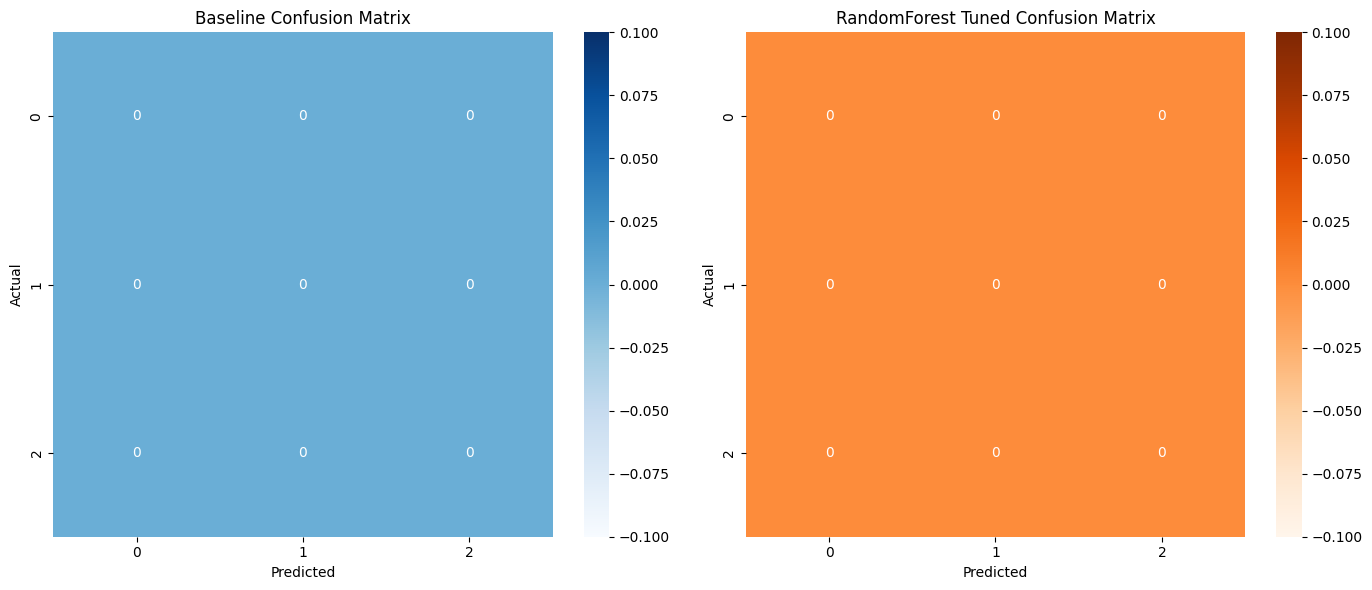

In [11]:
# Cell: Compare — Per-class metrics + confusion heatmaps (Baseline vs RF Tuned)
from pathlib import Path
import json
import pandas as pd
# Attempt to ensure numpy is present and >= 1.23 since matplotlib requires this
import importlib, subprocess, sys

def _version_tuple(v):
    try:
        parts = v.split('.')
        return tuple(int(p) for p in parts[:3])
    except Exception:
        return (0,0,0)
# Check if numpy is importable and has a compliant version
try:
    import numpy as np
    _np_ok = _version_tuple(np.__version__) >= (1,23,0)
except Exception:
    np = None
    _np_ok = False
if not _np_ok:
    print("NumPy missing or older than 1.23.\nDO NOT upgrade compiled libs in a running kernel — instead create a fresh environment or use the pinned `requirements.txt` / `environment.yml` and restart the kernel.")
    print('\nRecommended options:')
    print('  - conda create -n bigdata -f environment.yml  # or use conda install with pinned versions')
    print('  - pip install -r requirements.txt in a fresh virtualenv and restart kernel')

# Ensure plotting libs are available in the running kernel; if not, try to install them
# Note: matplotlib/seaborn are allowed to be installed; they are pure-Python wheels on many platforms.
def ensure_pkg(pkg_name):
    try:
        importlib.import_module(pkg_name)
    except Exception:
        print(f'Package {pkg_name} not found. Installing...')
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', pkg_name])
for _pkg in ('matplotlib', 'seaborn'):
    ensure_pkg(_pkg)
import matplotlib.pyplot as plt
import seaborn as sns

# Paths
RESULTS_DIR = Path('results') / 'metrics'
BASELINE_CONF = RESULTS_DIR / 'baseline_confusion_default.csv'
RF_TUNED_CONF = RESULTS_DIR / 'randomforest_tfidf_confusion_tuned.csv'
BASELINE_METRICS = RESULTS_DIR / 'baseline_logreg_default.json'
RF_TUNED_METRICS = RESULTS_DIR / 'randomforest_tfidf_tuned.json'
OUT_SUMMARY = RESULTS_DIR / 'comparison_baseline_rf_tuned_class_metrics.json'
PLOTS_DIR = RESULTS_DIR / 'plots'
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

# Helper: compute per-class precision/recall/f1 from confusion matrix DataFrame
def per_class_metrics(conf_df: pd.DataFrame):
    cm = conf_df.values.astype(float)
    tp = np.diagonal(cm)
    fp = cm.sum(axis=0) - tp
    fn = cm.sum(axis=1) - tp
    with np.errstate(divide='ignore', invalid='ignore'):
        precision = np.divide(tp, tp + fp, out=np.zeros_like(tp), where=(tp+fp)!=0)
        recall = np.divide(tp, tp + fn, out=np.zeros_like(tp), where=(tp+fn)!=0)
        f1 = np.divide(2 * precision * recall, precision + recall, out=np.zeros_like(tp), where=(precision+recall)!=0)
    classes = [int(c) if str(c).isdigit() else c for c in conf_df.columns]
    return pd.DataFrame({
        'class': classes,
        'tp': tp.tolist(),
        'precision': precision.tolist(),
        'recall': recall.tolist(),
        'f1': f1.tolist()
    })

# Load confusions
if BASELINE_CONF.exists() and RF_TUNED_CONF.exists():
    baseline_conf = pd.read_csv(BASELINE_CONF, index_col=0)
    rf_conf = pd.read_csv(RF_TUNED_CONF, index_col=0)

    # Ensure same label ordering: align both by union of labels
    labels = sorted(set(map(str, baseline_conf.index.tolist())) | set(map(str, rf_conf.index.tolist())), key=lambda x: int(x) if x.isdigit() else x)
    baseline_conf = baseline_conf.reindex(index=labels, columns=labels, fill_value=0)
    rf_conf = rf_conf.reindex(index=labels, columns=labels, fill_value=0)

    # Compute per-class metrics
    baseline_per_class = per_class_metrics(baseline_conf)
    rf_per_class = per_class_metrics(rf_conf)

    # Merge to compare
    compare_df = baseline_per_class.merge(rf_per_class, on='class', suffixes=('_baseline', '_rf_tuned'))

    # Save comparison
    comp_summary = {
        'per_class': compare_df.to_dict(orient='records'),
        'labels': labels
    }
    with open(OUT_SUMMARY, 'w', encoding='utf-8') as fh:
        json.dump(comp_summary, fh, indent=2)

    # Print a short tabular view
    display(compare_df)

    # Plot confusion heatmaps side-by-side
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    sns.heatmap(baseline_conf.astype(int), annot=True, fmt='d', cmap='Blues')
    plt.title('Baseline Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    plt.subplot(1, 2, 2)
    sns.heatmap(rf_conf.astype(int), annot=True, fmt='d', cmap='Oranges')
    plt.title('RandomForest Tuned Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    plot_file = PLOTS_DIR / 'confusion_baseline_vs_rf_tuned.png'
    plt.tight_layout()
    plt.savefig(plot_file, dpi=150, bbox_inches='tight')
    print('Saved confusion comparison plot to', str(plot_file))

else:
    print('Baseline or RF tuned confusion CSVs not found; please run baseline and RF cells first.')


hi